# Hyperparameter tuning
Using a random search.  
Notes:
* From experiment 4. Key words increased from ['spicy', 'chinese', 'fish', 'easy', 'indian'] to ['spicy', 'chinese', 'fish', 'easy', 'indian', 'lamb', 'pork', 'dessert', 'health', 'italian']

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from linucb import LinUCBModel
from sklearn.decomposition import PCA

from preprocessing import embed_mix
from evaluation import evaluate

import spacy
nlp = spacy.load('en_core_web_md')

In [3]:
df = pd.read_json('recipe_scraper/all_cuisines.json')


X_title = np.stack(df['title'].apply(lambda x : nlp(x).vector))
X_summary = np.stack(df['summary'].apply(lambda x : nlp(x).vector))
X_tags = np.stack(df['tags'].apply(lambda x : nlp(' '.join([xi for xi in x])).vector))

Tuning

In [13]:
N_samples=5
key_words = ['spicy', 'chinese', 'fish', 'easy', 'indian', 'lamb', 'pork', 'dessert', 'health', 'italian']

tuning_results = pd.DataFrame({'metric':[],
                              'alpha_title':[],
                              'alpha_summary':[],
                              'alpha_tags':[],
                              'embed_dim':[],
                              'linucb_alpha':[]
                             })

for n in range(N_samples):
    
    # random hyperparameter search
    alpha_title = np.random.rand()
    alpha_summary = np.random.rand()
    alpha_tags = np.random.rand()
    embed_dim = np.random.choice([50, 75, 100, 125, 150])
    linucb_alpha = np.random.rand()
    
    # linear combination of title/summary/tags embeddings.
    X = embed_mix(X_title, X_summary, X_tags, [alpha_title, alpha_summary, alpha_tags])
    
    # principle component analysis
    X = PCA(n_components=embed_dim).fit_transform(X)
    
    # normalise and add unit dimension
    X = X/np.linalg.norm(X, axis=1, keepdims=True)
    X = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
    
    # function that returns an initialised model object.
    model_gen = lambda : LinUCBModel(X, alpha=linucb_alpha)
    
    metric = evaluate(df, model_gen, key_words=key_words)
    
    tuning_results = tuning_results.append(pd.DataFrame({'metric':[metric],
                                                          'alpha_title':[alpha_title],
                                                          'alpha_summary':[alpha_summary],
                                                          'alpha_tags':[alpha_tags],
                                                          'embed_dim':[embed_dim],
                                                          'linucb_alpha':[linucb_alpha]
                                                         }
                                                       ),
                                           ignore_index=True
                                          )

# append results to store to save all experiment data

tuning_results_store = pd.read_csv('tuning_results_store.csv')

tuning_results['date_time'] = pd.Timestamp.now()
tuning_results['exp_id'] = tuning_results_store['exp_id'].max() + 1
tuning_results['run_id'] = tuning_results.index

tuning_results_store = tuning_results_store.append(tuning_results, ignore_index=True)
tuning_results_store.to_csv('tuning_results_store.csv', index=False)

In [14]:
tuning_results_store[tuning_results_store]

,metric,alpha_title,alpha_summary,alpha_tags,embed_dim,linucb_alpha,date_time,run_id,exp_id
0,6.530,0.204227,0.844016,0.619194,64.0,0.448282,2021-03-20 07:55:09.947522,0,0
1,6.650,0.697654,0.620435,0.436997,32.0,0.439594,2021-03-20 07:55:09.947522,1,0
2,7.740,0.156857,0.117320,0.874268,128.0,0.113930,2021-03-20 07:55:09.947522,2,0
3,6.790,0.891280,0.790607,0.309218,150.0,1.606229,2021-03-20 08:11:17.864302,0,1
4,6.990,0.272805,0.334044,0.326977,50.0,1.888515,2021-03-20 08:11:17.864302,1,1
5,6.760,0.470196,0.496277,0.448109,50.0,1.760948,2021-03-20 08:11:17.864302,2,1
6,7.190,0.456952,0.140710,0.689346,125.0,0.340672,2021-03-20 08:11:17.864302,3,1
7,6.540,0.920012,0.392608,0.390364,125.0,1.509775,2021-03-20 08:11:17.864302,4,1
8,6.370,0.236603,0.882797,0.479563,150.0,0.821742,2021-03-20 08:18:56.216488,0,2
9,6.920,0.904772,0.543643,0.171517,150.0,0.515878,2021-03-20 08:18:56.216488,1,2


In [18]:
print('Best hyperparameters:')
tuning_results_store.loc[tuning_results_store['metric'].idxmax()]

Best hyperparameters:


metric                                 7.74
alpha_title                        0.156857
alpha_summary                       0.11732
alpha_tags                         0.874268
embed_dim                               128
linucb_alpha                        0.11393
date_time        2021-03-20 07:55:09.947522
run_id                                    2
exp_id                                    0
Name: 2, dtype: object

In [28]:
print('Best hyperparameters:')
tuning_results_store.loc[tuning_results_store['metric'].idxmax()]

Best hyperparameters:


metric                                 7.74
alpha_title                        0.156857
alpha_summary                       0.11732
alpha_tags                         0.874268
embed_dim                               128
linucb_alpha                        0.11393
date_time        2021-03-20 07:55:09.947522
run_id                                    2
exp_id                                    0
Name: 2, dtype: object

<Figure size 432x288 with 0 Axes>

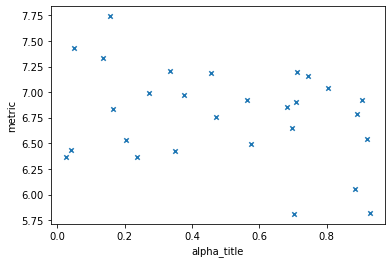

<Figure size 432x288 with 0 Axes>

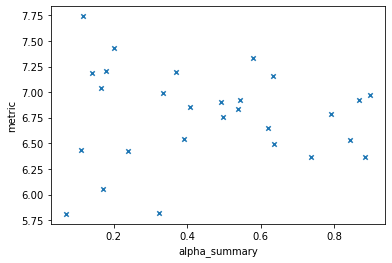

<Figure size 432x288 with 0 Axes>

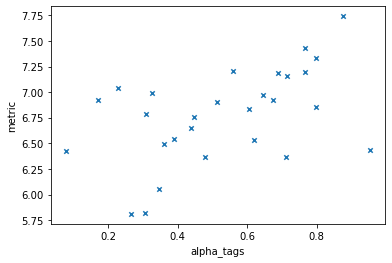

<Figure size 432x288 with 0 Axes>

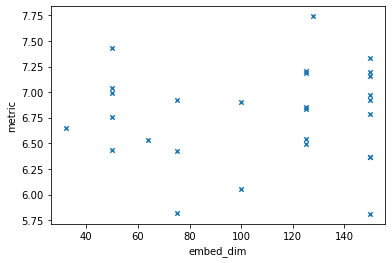

<Figure size 432x288 with 0 Axes>

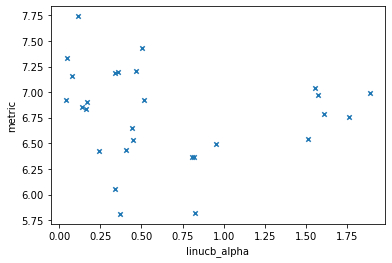

In [29]:
hyperparams = ['alpha_title', 'alpha_summary', 'alpha_tags', 'embed_dim', 'linucb_alpha']

for hyperparam in hyperparams:
    plt.figure()
    tuning_results_store.sort_values(by=hyperparam).plot(x=hyperparam, y='metric', marker='x', kind='scatter')

# Saving preprocessed inputs

In [5]:
from preprocessing import preprocess

In [42]:
tuning_results_store = pd.read_csv('tuning_results_store.csv')
tuned_hyperparams = tuning_results_store.loc[tuning_results_store['metric'].idxmax()]

# preprocess
X = preprocess(df, 
               alpha_title=tuned_hyperparams['alpha_title'], 
               alpha_summary=tuned_hyperparams['alpha_summary'], 
               alpha_tags=tuned_hyperparams['alpha_tags'], 
               embed_dim=int(tuned_hyperparams['embed_dim'])
              )

In [65]:
tuned_inputs = {'X': X, 'linucb_alpha': tuned_hyperparams['linucb_alpha']}
np.save('tuned_inputs', tuned_inputs)